# Unveiling Retail Dynamics: "Mining Predictive Insights and Customer Segmentation from Online Retail Data"

# Abstract

# Introduction

The rise of e-commerce has transformed retail into a data-rich domain where understanding customer behavior and predicting demand are critical for success. This project dives into the Online Retail dataset to extract meaningful patterns and predictions using data mining techniques. Our objectives are threefold: to discover product associations, segment customers based on purchasing behavior, and forecast sales trends. Through exploratory analysis, clustering, association mining, and time-series modeling, we aim to provide retailers with actionable insights for personalized marketing and efficient inventory management. 

## Research Questions
1. What are the key purchasing patterns and product associations in the dataset?

2. How can customers be segmented based on their purchasing behavior?

3. Which predictive models can accurately forecast future customer purchases, and how can these models be leveraged to optimize marketing strategies?

# Data Overview

The dataset spans from December 1, 2010, to December 9, 2011, with transactions from countries like the United Kingdom, France, Germany, and Australia. It contains 541,909 rows and the following key variables:

**InvoiceNo:** Transaction identifier (e.g., "536365", some with "C" indicating cancellations).

**StockCode:** Product identifier (e.g., "85123A").

**Description:** Product name (e.g., "WHITE HANGING HEART T-LIGHT HOLDER").

**Quantity:** Units sold (positive for sales, negative for returns, e.g., -1 in "C536379").

**InvoiceDate:** Date and time (e.g., "2010-12-01 08:26:00").

**UnitPrice:** Price per unit (e.g., 2.55).

**CustomerID:** Customer identifier (e.g., 17850.0, some NaN).

**Country:** Transaction location (e.g., "United Kingdom").

# Importing Required Libraries 

In [233]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px
import geopandas as gpd
from datetime import datetime
import re
from scipy import stats
import logging
import missingno as msno
from collections import Counter
from itertools import combinations
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
%matplotlib inline


## Data Importing, Cleaning & Preprocessing 

 ## 1. Read the data

Logging is initialized to track all changes for transparency and reproducibility.

In [160]:
# Set up logging
logging.basicConfig(filename='cleaning_log.log', level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

# Load dataset
df = pd.read_excel("Online Retail.xlsx")
original_shape = df.shape
logging.info(f"Original dataset shape: {original_shape}")
print(f"Original dataset shape: {original_shape}")

Original dataset shape: (541909, 8)


## 1.1 Initial Exploration

Here is a glimpse of first & last 5 rows of our dataset:

In [161]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [162]:
df.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


Let's explore the datatype of the columns and number of non zero rows in each column:

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2. Data Cleaning 

### 2.1 Handling Missing Values

First, I have found below that the dataset has missing values in two columns (Description and Customer ID). Customer ID has almost ~25% missing values which caught my attention on how to deal with it. 

<Axes: >

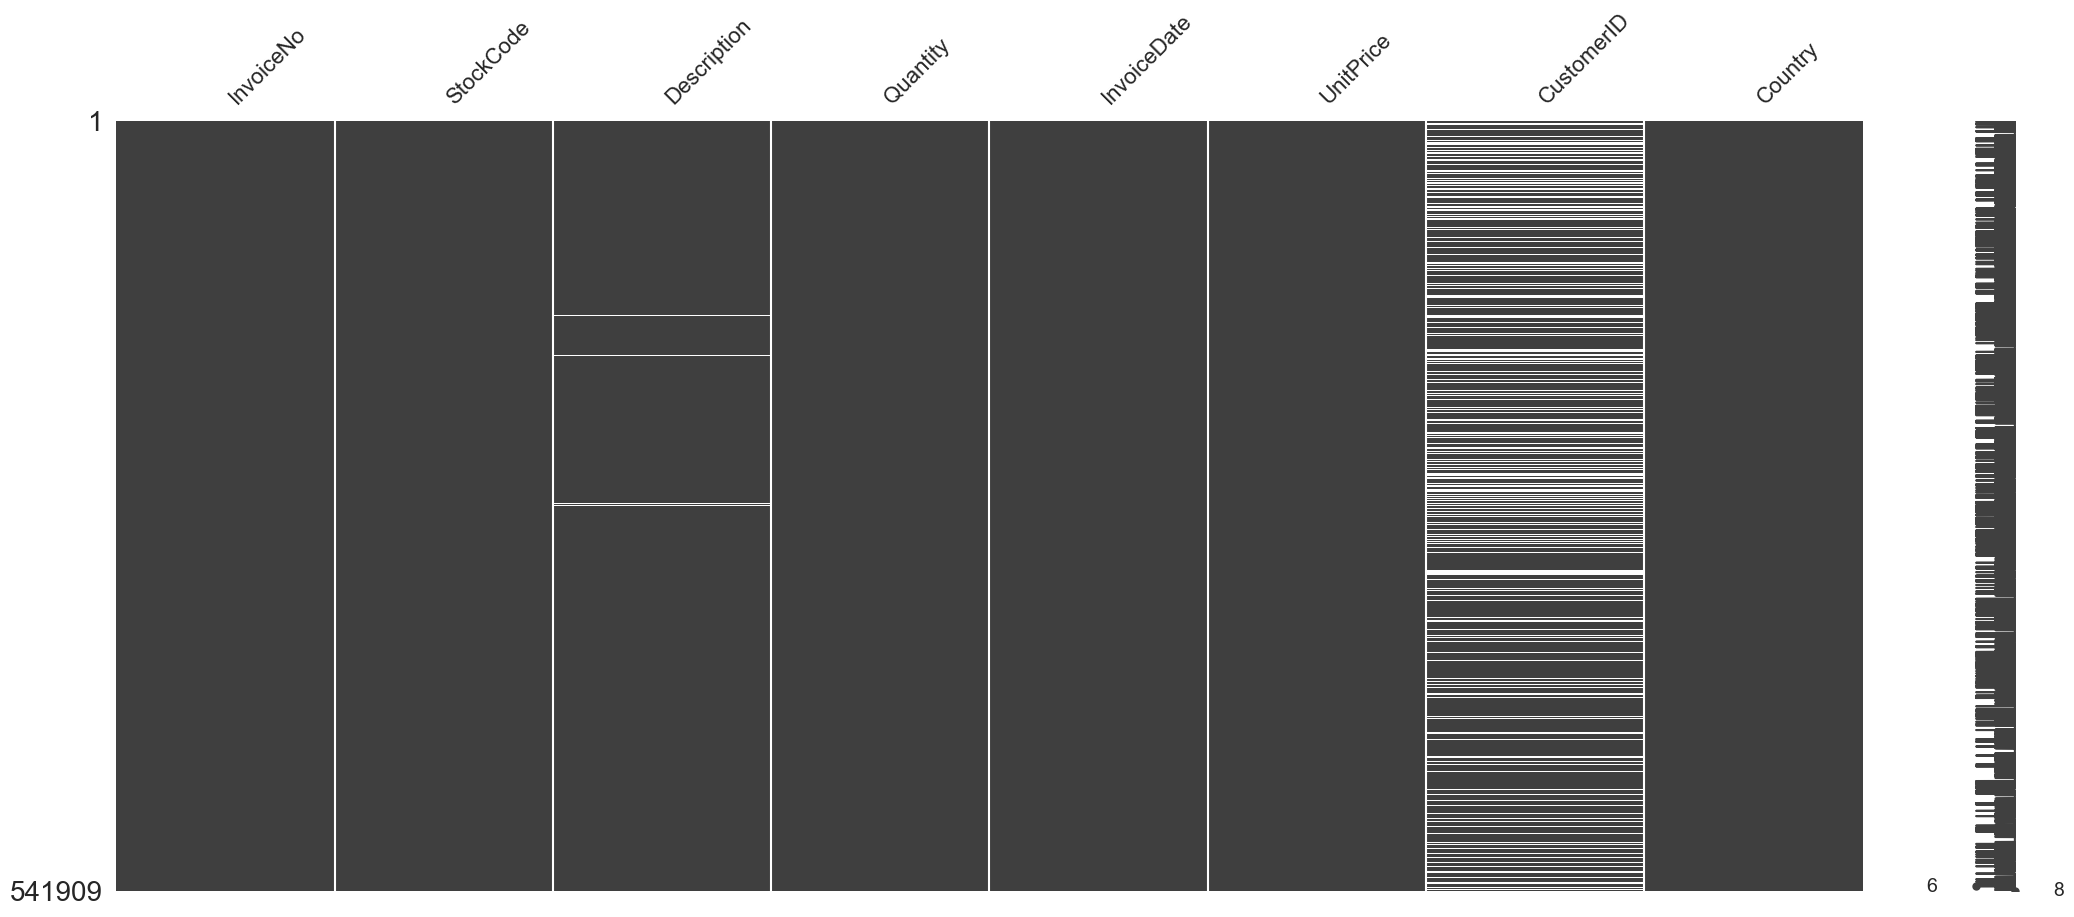

In [164]:
msno.matrix(df)

Missing Values Report:


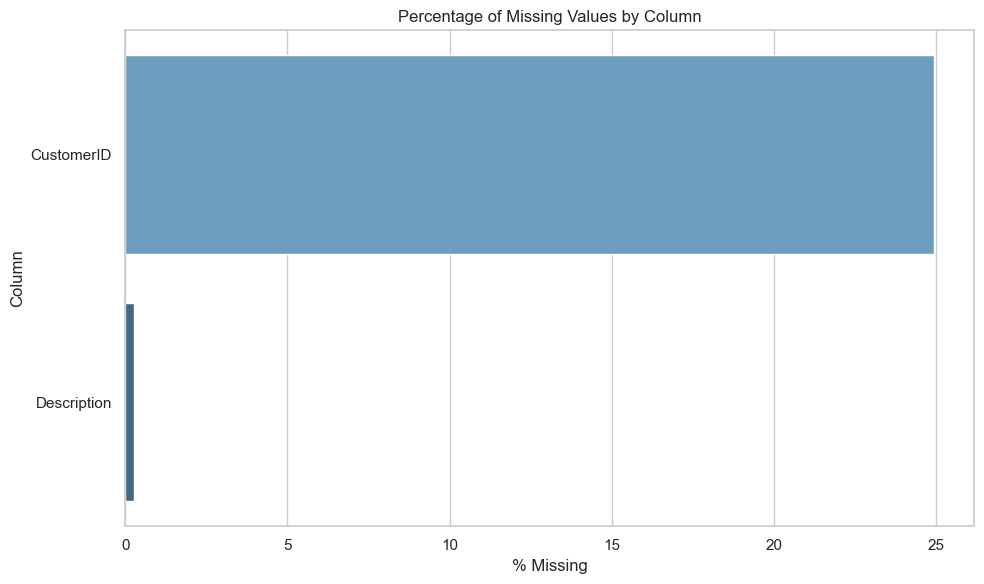

            Data Type  Missing Values  % Missing  Total Rows
CustomerID    float64          135080      24.93      541909
Description    object            1454       0.27      541909


In [165]:
def missing_values_report(df, show_all=False, plot=True):
    total = df.isnull().sum()
    percent = (total / df.shape[0]) * 100
    dtype = df.dtypes
    count = df.shape[0]

    summary = pd.DataFrame({
        'Data Type': dtype,
        'Missing Values': total,
        '% Missing': percent,
        'Total Rows': count
    })

    if not show_all:
        summary = summary[summary['Missing Values'] > 0]

    summary.sort_values(by='% Missing', ascending=False, inplace=True)

    if plot and not summary.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            y=summary.index, 
            x=summary['% Missing'], 
            palette='Blues_d'
        )
        plt.title('Percentage of Missing Values by Column')
        plt.xlabel('% Missing')
        plt.ylabel('Column')
        plt.tight_layout()
        plt.show()

    return summary.round(2)

# Usage
print("Missing Values Report:")
missing_report = missing_values_report(df)
print(missing_report)


Based on the missing value report:

- `Description` has very few missing values (~0.27%). We can simply fill them with `'Unknown'`.
- `CustomerID` is missing in about 25% of rows. Possible strategies:
    - Drop these rows if CustomerID is critical for customer-level analysis.
    - Treat these as **Guest Customers** by creating a `IsGuest` flag and imputing a generic GuestID.

**Decision:**
- Flagged missing `CustomerID` as `IsGuest = True`.
- Imputed missing `Description` values using the most common description (`mode`) per `StockCode`.
- Dropped any remaining rows where no valid `Description` was available (ensuring product data quality).
- Replaced missing `CustomerID` with placeholder `-1` to maintain datatype consistency.


In [166]:
logging.info(f"Missing values before handling: {df.isnull().sum().to_dict()}")
df['IsGuest'] = df['CustomerID'].isna()  # Flag missing CustomerID
df['CustomerID'] = df['CustomerID'].fillna(-1)  # Placeholder -1 for consistency
df['Description'] = df.groupby('StockCode')['Description'].transform(
    lambda x: x.mode()[0] if x.notna().any() else np.nan  # Impute with mode
)
df.dropna(subset=['Description'], inplace=True)  # Drop rows with no valid Description
logging.info(f"Shape after handling missing values: {df.shape}")
print(f"Shape after handling missing values: {df.shape}")
print(f"Guest rows (IsGuest = True): {df['IsGuest'].sum()}")
print(f"Rows dropped due to missing Description: {original_shape[0] - df.shape[0]}")

Shape after handling missing values: (541797, 9)
Guest rows (IsGuest = True): 134968
Rows dropped due to missing Description: 112


- Dataset reduced from 541,909 rows to 541,797 rows (112 rows dropped due to missing Description with no mode available).
- 134,968 transactions are flagged as Guest purchases (`IsGuest = True`) with `CustomerID = -1`.
- All remaining `Description` values are either imputed or valid.
- **99.97% of the original data** is preserved after cleaning.

This ensures minimal data loss while maintaining the integrity of product and customer information for further analysis.


### 2.2 Formating Strings

Inconsistent string formats (e.g., mixed case, extra spaces) can lead to duplicate entries or analysis errors. I first standardize strings to uppercase and remove excess whitespace for consistency.

In [167]:
df['Description'] = df['Description'].str.upper().str.strip().replace(r'\s+', ' ', regex=True)
df['StockCode'] = df['StockCode'].astype(str).str.upper()  # Convert to string first
df['Country'] = df['Country'].str.upper()
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
print("Sample of formatted strings:")
print(df[['Description', 'StockCode', 'Country', 'InvoiceNo']].head())
print(f"StockCode missing after formatting: {df['StockCode'].isnull().sum()}")

Sample of formatted strings:
                           Description StockCode         Country InvoiceNo
0   WHITE HANGING HEART T-LIGHT HOLDER    85123A  UNITED KINGDOM    536365
1                  WHITE METAL LANTERN     71053  UNITED KINGDOM    536365
2       CREAM CUPID HEARTS COAT HANGER    84406B  UNITED KINGDOM    536365
3  KNITTED UNION FLAG HOT WATER BOTTLE    84029G  UNITED KINGDOM    536365
4       RED WOOLLY HOTTIE WHITE HEART.    84029E  UNITED KINGDOM    536365
StockCode missing after formatting: 0


Strings are now uniformly uppercase with single spaces (e.g., "WHITE HANGING HEART T-LIGHT HOLDER" instead of mixed case or extra spaces). InvoiceNo is converted to string format to handle cancellations (e.g., "C536379") consistently.

### 2.3 Identifying and Handling Cancellations

Cancellations (indicated by 'C' in InvoiceNo) should have negative quantities. Inconsistent entries (e.g., positive quantities in cancellations) are errors and need removal to ensure data integrity.

In [168]:
# Identify Cancellations
df['IsCancelled'] = df['InvoiceNo'].str.startswith('C')

# Find inconsistencies
cancelled_positive_qty = df[df['IsCancelled'] & (df['Quantity'] > 0)]
non_cancelled_negative_qty = df[~df['IsCancelled'] & (df['Quantity'] < 0)]

# Total inconsistent rows
total_inconsistent = len(cancelled_positive_qty) + len(non_cancelled_negative_qty)

# Drop inconsistent rows if any
if total_inconsistent > 0:
    df.drop(index=cancelled_positive_qty.index.union(non_cancelled_negative_qty.index), inplace=True)
    logging.info(f"Dropped {len(cancelled_positive_qty)} positive qty cancellations and {len(non_cancelled_negative_qty)} negative qty non-cancellations")
    print(f"Dropped {len(cancelled_positive_qty)} positive qty cancellations and {len(non_cancelled_negative_qty)} negative qty non-cancellations")
else:
    logging.info("No inconsistent cancellations found")
    print("No inconsistent cancellations found")

# After cleaning
print(f"Shape after handling cancellations: {df.shape}")
print(f"Total valid cancellations retained: {df['IsCancelled'].sum()}")


Dropped 0 positive qty cancellations and 1239 negative qty non-cancellations
Shape after handling cancellations: (540558, 10)
Total valid cancellations retained: 9288


Here 0 positive qty cancellations are dropped and 1239 negative qty non-cancellations (adjustments not marked as 'C'), reducing the dataset to 540558 rows. Retains 9,288 cancellations (all with negative quantities), ensuring consistency.

### 2.4 Remove Non-Product Transactions

Certain transactions represent non-product activities, such as:
- Postage charges (`POST`)
- Manual adjustments (`DOT`, `M`)
- Miscellaneous non-sales entries

In [169]:
# Remove Non-Product Transactions

non_product_codes = df['StockCode'].str.match(r'^[A-Za-z]+$').fillna(False)
df = df[~non_product_codes]
logging.info(f"Dropped {non_product_codes.sum()} non-product transactions")
print(f"Dropped {non_product_codes.sum()} non-product transactions")
print(f"Shape after removing non-products: {df.shape}")


Dropped 2759 non-product transactions
Shape after removing non-products: (537799, 10)


Dropped 2,759 non-product transactions (e.g., "POST", "M"), reducing the dataset to 537,799 rows, refining the focus to product-based sales.

### 2.5 Remove Zero/Negative UnitPrice

Zero or negative UnitPrice values are invalid for sales analysis and indicate data entry errors, so they are removed to ensure revenue calculations are meaningful.

In [170]:
df = df[df['UnitPrice'] > 0]
logging.info(f"Shape after removing zero/negative UnitPrice: {df.shape}")
print(f"Shape after removing zero/negative UnitPrice: {df.shape}")


Shape after removing zero/negative UnitPrice: (536649, 10)


1150 rows have been dropped that had negative unitprice, remaining 536,649 rows.

### 2.6 Quantity Outlier Detection and Handling


Outliers in `Quantity` can severely skew revenue calculations and customer segmentation results.

Some transactions may have extremely large quantities (e.g., buying 5,000 units in one transaction), which may represent:
- Corporate/bulk orders
- Data entry errors
- Promotional transactions

Therefore, it is important to:
- Detect extreme Quantity outliers
- Analyze their distribution
- Decide on a strategy to handle them carefully to avoid distorting the analysis while minimizing unnecessary data loss.

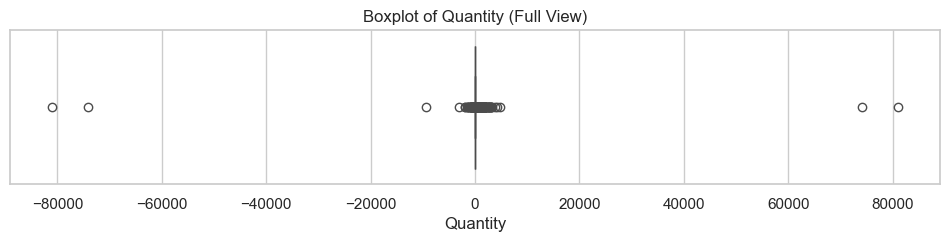

In [171]:
# Boxplot 
plt.figure(figsize=(12,2))
sns.boxplot(x=df['Quantity'])
plt.title('Boxplot of Quantity (Full View)')
plt.xlabel('Quantity')
plt.show()


## 2.6 Quantity Outlier Detection and Cleaning Strategy

After reviewing the Quantity distribution more carefully,  
I found that transactions with quantities up to a few hundred units could still represent real business behavior.

However, quantities above 5,000 units are extremely rare and likely represent bulk wholesale orders or data entry issues.

To clean the data without losing valid transactions:
- I first remove any transactions where Quantity ≤ 0.
- Then remove only transactions where Quantity > 5,000.

This approach keeps the dataset realistic and avoids unnecessary data loss.



In [ ]:
# Save original number of rows before cleaning
original_shape = df.shape[0]

# Step 1: Remove dirty negative or zero quantities
df = df[df['Quantity'] > 0]

# Step 2: Remove extremely high quantities (>5000)
df = df[df['Quantity'] <= 5000]

# New number of rows after cleaning
new_shape = df.shape[0]

# Calculate how many rows were dropped
rows_dropped = original_shape - new_shape

print(f"Original dataset shape: {original_shape} rows")
print(f"New dataset shape after Quantity cleaning: {new_shape} rows")
print(f"Total rows dropped: {rows_dropped} ({(rows_dropped / original_shape) * 100:.4f}% of the dataset)")

# Save cleaned dataset
df.to_csv('dataset_cleaned.csv', index=False)



Original dataset shape: 536649 rows
New dataset shape after Quantity cleaning: 527916 rows
Total rows dropped: 8733 (1.6273% of the dataset)


After removing transactions with negative or zero quantities and filtering out quantities above 5,000 units:

- Dropped 8,733 transactions (~1.63% of the data).
- Dataset reduced from 536,649 to 527,916 rows.

This ensures realistic customer behavior while keeping almost all valuable data intact.


## 3. Data Preprocessing

### 3.1 Format InvoiceDate

I now convert the `InvoiceDate` column to proper datetime format.

This is a critical step because:
- It enables us to extract time-based features like month, day of the week, and hour.
- It ensures smooth handling of dates during trend, seasonality, and cohort analysis later.

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

print("Sample InvoiceDate:")
print(df['InvoiceDate'].head())

Sample InvoiceDate:
0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


InvoiceDate is now a datetime object (e.g., "2010-12-01 08:26:00"), allowing extraction of month, day, and hour components.

### 3.2 Feature Engineering

To enriched the dataset I am creating several new features:

- `Revenue`: Calculated as Quantity × UnitPrice for each transaction.
- `InvoiceMonth`: Extracted the full month name from InvoiceDate.
- `InvoiceDay`: Extracted the day of the week (e.g., Monday, Tuesday).
- `InvoiceHour`: Extracted the hour of the day the transaction occurred.
- `IsWeekend`: Flagged whether the transaction happened on a weekend.

*These features will help us better understand revenue patterns, seasonal trends, and customer behavior over time.*


In [173]:
# Feature Engineering
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].dt.strftime('%B')
df['InvoiceDay'] = df['InvoiceDate'].dt.day_name()
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['IsWeekend'] = df['InvoiceDate'].dt.weekday >= 5

# Check the new features
print("Sample of new features:")
print(df[['Revenue', 'InvoiceMonth', 'InvoiceDay', 'InvoiceHour', 'IsWeekend']].head())


Sample of new features:
   Revenue InvoiceMonth InvoiceDay  InvoiceHour  IsWeekend
0    15.30     December  Wednesday            8      False
1    20.34     December  Wednesday            8      False
2    22.00     December  Wednesday            8      False
3    20.34     December  Wednesday            8      False
4    20.34     December  Wednesday            8      False


Adding Revenue (e.g., 15.30 for 6 units at £2.55), InvoiceMonth (e.g., "December"), InvoiceDay (e.g., "Wednesday"), InvoiceHour (e.g., 8), and IsWeekend (e.g., False), providing a richer dataset for analysis.

### 3.3 Standardize UnitPrice for Stable Products

Varying UnitPrice for the same StockCode may reflect errors or discounts. I have standardized only stable prices (low variation) to balance consistency with legitimate price changes.

In [174]:
# Calculate price variation
price_variation = df.groupby('StockCode')['UnitPrice'].agg(['mean', 'std']).reset_index()
price_variation['PriceStability'] = price_variation['std'] / price_variation['mean']

# Identify stable products
stable_prices = price_variation[price_variation['PriceStability'] < 0.1]['StockCode']

# Standardize UnitPrice for stable products
df.loc[df['StockCode'].isin(stable_prices), 'UnitPrice'] = df.groupby('StockCode')['UnitPrice'].transform('mean')

# Check result
print(f"Number of stable products standardized: {len(stable_prices)}")
print("Sample price variation:")
print(price_variation.head())


Number of stable products standardized: 760
Sample price variation:
  StockCode      mean       std  PriceStability
0     10002  1.086620  0.367792        0.338474
1     10080  0.410909  0.098072        0.238672
2     10120  0.210000  0.000000        0.000000
3    10123C  0.650000  0.000000        0.000000
4    10124A  0.420000  0.000000        0.000000


As a result, 760 stable products (coefficient of variation < 10%) have been identified and standardized their UnitPrice to the mean, ensuring consistency for frequently sold items while preserving variability in others.

### 3.4 Encode Categorical Variables

Machine learning models require numerical input rather than text.

To prepare the data, we encoded the `Country` column into a new numeric feature called `CountryCode`:
- Each country is assigned a unique integer code (e.g., "UNITED KINGDOM" → 35).
- A total of 38 unique countries were mapped to codes ranging from 0 to 37.

This encoding step ensures that country information can be used effectively in future modeling.

In [175]:
# Encode Country as numeric codes
df['CountryCode'] = pd.Categorical(df['Country']).codes

# Check result
print("Sample of Country and CountryCode:")
print(df[['Country', 'CountryCode']].head())


Sample of Country and CountryCode:
          Country  CountryCode
0  UNITED KINGDOM           35
1  UNITED KINGDOM           35
2  UNITED KINGDOM           35
3  UNITED KINGDOM           35
4  UNITED KINGDOM           35


Adding CountryCode (e.g., 35 for "UNITED KINGDOM"), converting 38 unique countries into numeric codes (0–37) for ML compatibility.

### 3.5 Resolve Duplicate CustomerIDs

I noticed that some customers had transactions recorded in multiple countries.

Since a single CustomerID should logically belong to one country,  
we resolved this inconsistency by:

- Identifying CustomerIDs associated with more than one country.
- Assigning each customer the country that appeared most frequently (the mode).



In [176]:
# Find customers appearing in multiple countries
customer_countries = df.groupby('CustomerID')['Country'].nunique()
multi_country_customers = customer_countries[customer_countries > 1].index

# Reassign each multi-country customer to their most frequent (mode) country
for cid in multi_country_customers:
    mode_country = df[df['CustomerID'] == cid]['Country'].mode()[0]
    df.loc[df['CustomerID'] == cid, 'Country'] = mode_country

# Log and print results
logging.info(f"Resolved {len(multi_country_customers)} customers with multiple countries")
print(f"Resolved {len(multi_country_customers)} customers with multiple countries")


Resolved 9 customers with multiple countries


Resolved 9 customers with multiple countries (e.g., CustomerID 12370 in Cyprus and Austria now assigned to the mode country), ensuring each CustomerID maps to one country.

## 4 Exploratory Data Analysis

### 4.1 Basic Statistical Analysis

Providing an overview of the dataset’s structure and summary statistics to validate cleaning and preprocessing.

In [177]:
print("Dataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 527916 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     527916 non-null  object        
 1   StockCode     527916 non-null  object        
 2   Description   527916 non-null  object        
 3   Quantity      527916 non-null  int64         
 4   InvoiceDate   527916 non-null  datetime64[ns]
 5   UnitPrice     527916 non-null  float64       
 6   CustomerID    527916 non-null  float64       
 7   Country       527916 non-null  object        
 8   IsGuest       527916 non-null  bool          
 9   IsCancelled   527916 non-null  bool          
 10  Revenue       527916 non-null  float64       
 11  InvoiceMonth  527916 non-null  object        
 12  InvoiceDay    527916 non-null  object        
 13  InvoiceHour   527916 non-null  int32         
 14  IsWeekend     527916 non-null  bool          
 15  CountryC

Confirmed that the final dataset contains 527,916 rows with no missing values.  
Numeric columns such as Quantity, UnitPrice, and Revenue show reasonable value ranges, validating the cleaning steps.  
Datetime and categorical fields are correctly formatted, and newly created features are complete and ready for analysis.


### 4.2 Distribution of Orders Across Countries

To understand the geographical concentration of customer orders, I first visualize the share of orders between the **United Kingdom** and **other countries** using a pie chart.  
I then plot a world map to display the distribution of international orders (excluding the UK) by country intensity.

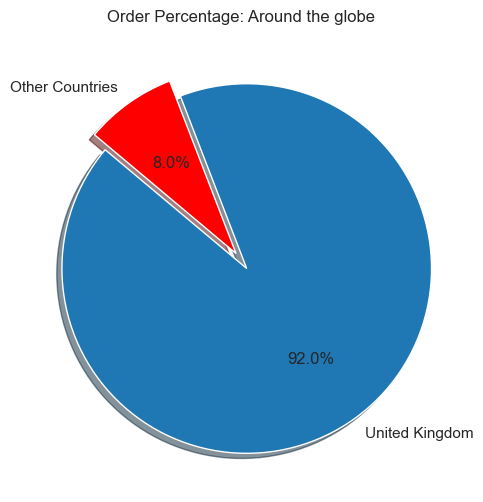

In [206]:
import matplotlib.pyplot as plt
import pandas as pd

# Orders per country
order_counts = df['Country'].value_counts()

# Separate UK and Others
uk_orders = order_counts['UNITED KINGDOM']
other_orders = order_counts.drop('UNITED KINGDOM').sum()

# Create a new series
final_order_data = pd.Series({
    'United Kingdom': uk_orders,
    'Other Countries': other_orders
})

# Plot Pie Chart
plt.figure(figsize=(7, 6))
final_order_data.plot.pie(
    autopct='%1.1f%%', 
    startangle=140, 
    shadow=True, 
    explode=[0.05, 0.05], 
    colors=['#1f77b4', 'red']
)
plt.title('Order Percentage: Around the globe')
plt.ylabel('')  # Remove y-axis label
plt.show()



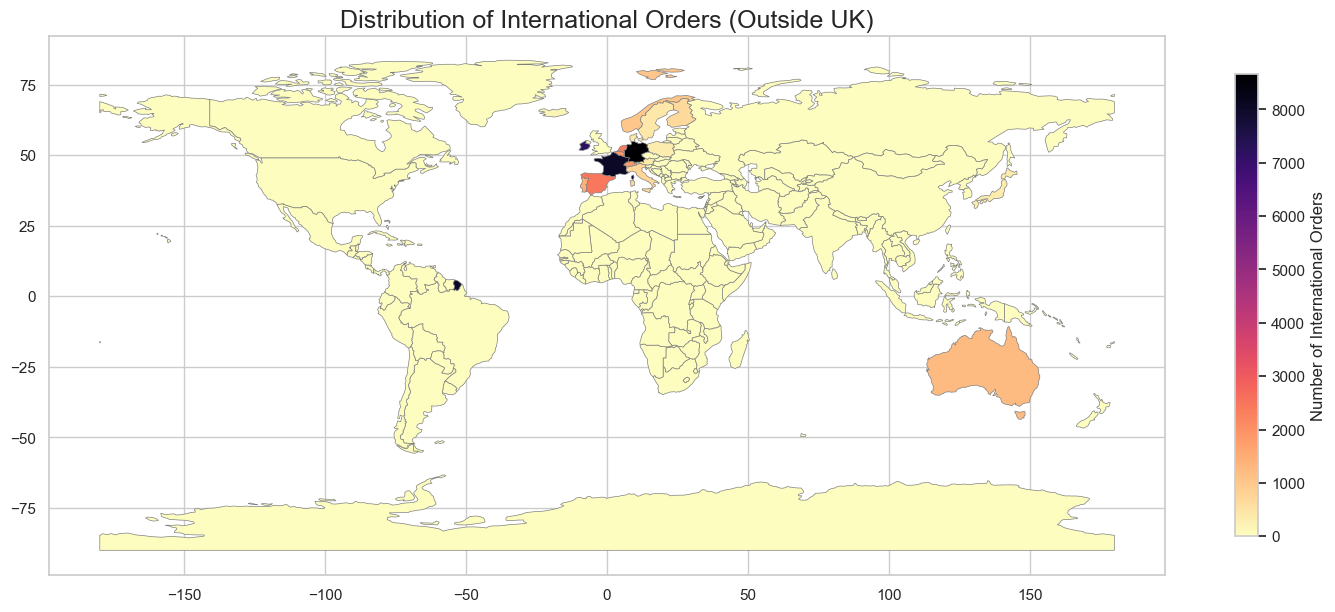

In [205]:
# Load world map
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Prepare order counts
order_country_df = df['Country'].value_counts().reset_index()
order_country_df.columns = ['Country', 'OrderCount']

# Mapping based on your real data
country_mapping = {
    'UNITED KINGDOM': 'United Kingdom',
    'GERMANY': 'Germany',
    'FRANCE': 'France',
    'EIRE': 'Ireland',
    'SPAIN': 'Spain',
    'NETHERLANDS': 'Netherlands',
    'BELGIUM': 'Belgium',
    'SWITZERLAND': 'Switzerland',
    'PORTUGAL': 'Portugal',
    'AUSTRALIA': 'Australia',
    'NORWAY': 'Norway',
    'CHANNEL ISLANDS': 'United Kingdom',  # Merge into UK
    'ITALY': 'Italy',
    'FINLAND': 'Finland',
    'CYPRUS': 'Cyprus',
    'SWEDEN': 'Sweden',
    'DENMARK': 'Denmark',
    'AUSTRIA': 'Austria',
    'POLAND': 'Poland',
    'JAPAN': 'Japan',
    'ISRAEL': 'Israel',
    'SINGAPORE': 'Singapore',
    'ICELAND': 'Iceland',
    'BRAZIL': 'Brazil',
    'CZECH REPUBLIC': 'Czechia',  # New official name
    'BAHRAIN': 'Bahrain',
    'SAUDI ARABIA': 'Saudi Arabia'
}

# Apply the mapping
order_country_df['Country'] = order_country_df['Country'].replace(country_mapping)

# Exclude United Kingdom
order_country_df = order_country_df[order_country_df['Country'] != 'United Kingdom']

# Merge with world map
world = world.merge(order_country_df, how='left', left_on='NAME', right_on='Country')

# Fill missing values with 0 (no orders)
world['OrderCount'] = world['OrderCount'].fillna(0)

# Plot the map
fig, ax = plt.subplots(figsize=(18, 12))
world.plot(
    column='OrderCount',
    cmap='magma_r',
    edgecolor='gray',
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': "Number of International Orders", 'shrink': 0.5},
    missing_kwds={"color": "lightgrey"},
    ax=ax
)

# Final touches
ax.set_title('Distribution of International Orders (Outside UK)', fontsize=18)
ax.grid(True)

plt.show()

- The **United Kingdom** accounts for about **92%** of all transactions, highlighting a heavy domestic focus.
- Only **8%** of the orders come from **international markets**, emphasizing a strong opportunity for international growth.
- Among international customers, **Germany**, **France**, **Ireland**, **Spain**, and **Netherlands** are the leading contributors.
- Other countries like **Australia**, **Belgium**, **Switzerland**, and **Portugal** show moderate order volumes.

- The world map confirms that **continental Europe** is the company's primary international market.


### 4.3 Revenue by Country

Here i want to Identify top revenue-generating countries, highlighting market focus.

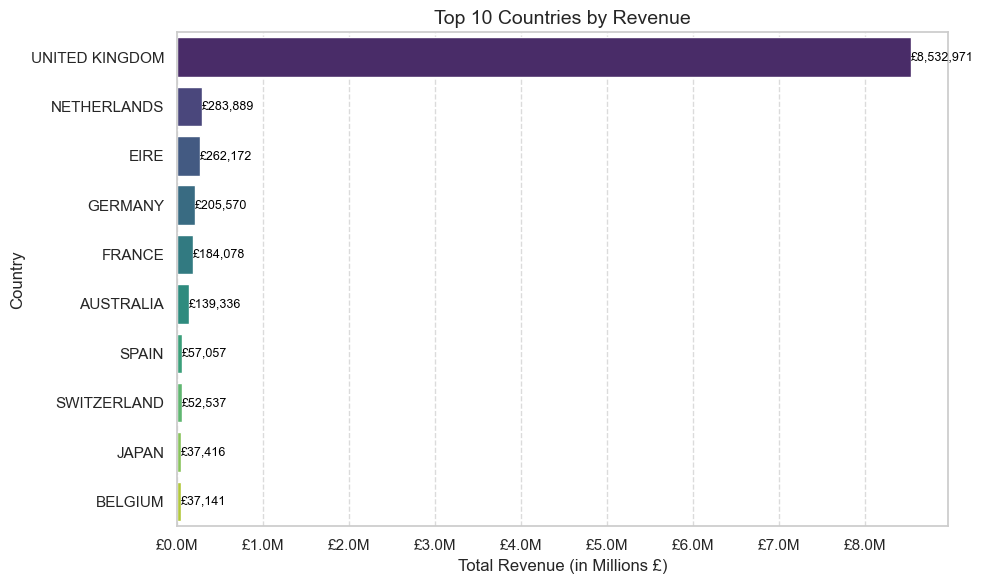

In [237]:
# Grouping by Country and summing the Revenue
country_revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='viridis')

# Title and labels
plt.title("Top 10 Countries by Revenue", fontsize=14)
plt.xlabel("Total Revenue (in Millions £)")
plt.ylabel("Country")

# Format x-axis ticks in Millions (eg. 1M, 2M, 3M)
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'£{x/1e6:.1f}M'))

# Annotate each bar with exact revenue (with commas)
for index, value in enumerate(country_revenue.values):
    plt.text(value, index, f'£{value:,.0f}', va='center', ha='left', fontsize=9, color='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The UK leads overwhelmingly (over £8M), followed by distant second-tier countries (e.g., Netherlands, EIRE), confirming the dataset’s UK-centric nature.

### 4.4 Monthly Order Analysis

I visualize the number of orders placed each month and annotate the percentage contribution of each month to total orders. This highlights seasonal patterns while keeping the plot compact.




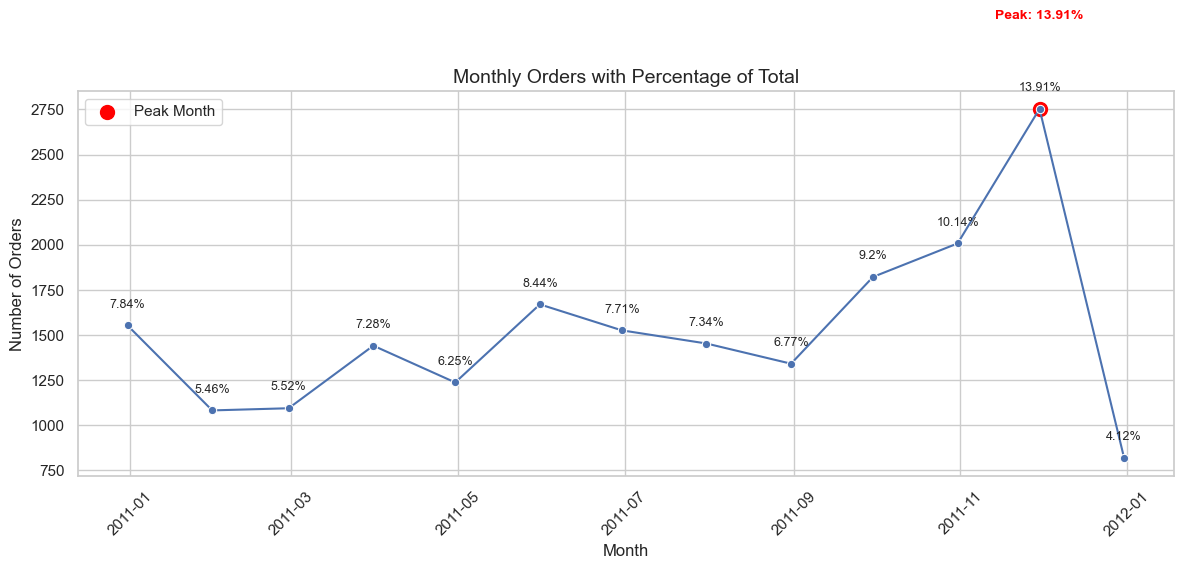

In [221]:
# --- Monthly Orders with Percentages ---
orders_by_month = df.set_index('InvoiceDate').resample('M')['InvoiceNo'].nunique()
orders_by_month_table = orders_by_month.reset_index()
orders_by_month_table['% of Total Orders'] = (orders_by_month_table['InvoiceNo'] / orders_by_month_table['InvoiceNo'].sum() * 100).round(2)

# Find the Peak Month
peak_idx = orders_by_month_table['InvoiceNo'].idxmax()
peak_month = orders_by_month_table.loc[peak_idx, 'InvoiceDate']
peak_orders = orders_by_month_table.loc[peak_idx, 'InvoiceNo']
peak_percent = orders_by_month_table.loc[peak_idx, '% of Total Orders']

# --- Plot ---
plt.figure(figsize=(12,6))

# Line Plot
sns.lineplot(x=orders_by_month.index, y=orders_by_month.values, marker='o')
plt.title('Monthly Orders with Percentage of Total', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)

# Annotate % on points
for i in range(len(orders_by_month_table)):
    plt.text(orders_by_month_table['InvoiceDate'][i], 
             orders_by_month_table['InvoiceNo'][i] + 100, 
             f"{orders_by_month_table['% of Total Orders'][i]}%", 
             ha='center', fontsize=9)

# Highlight Peak Month
plt.scatter(peak_month, peak_orders, color='red', s=100, label='Peak Month')
plt.text(peak_month, peak_orders + 500, f"Peak: {peak_percent}%", color='red', fontsize=10, fontweight='bold', ha='center')

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Monthly orders show a steady pattern throughout 2011, with notable growth starting from **September**.  
**November** records the highest share, contributing **13.91%** of all orders — likely boosted by the holiday season.  


### 4.5 Day of Week Order Analysis

Here i have visualized how customer orders are distributed across the days of the week.  
Each bar is annotated with its percentage share, and the peak day (highest number of orders) is highlighted in red for emphasis.



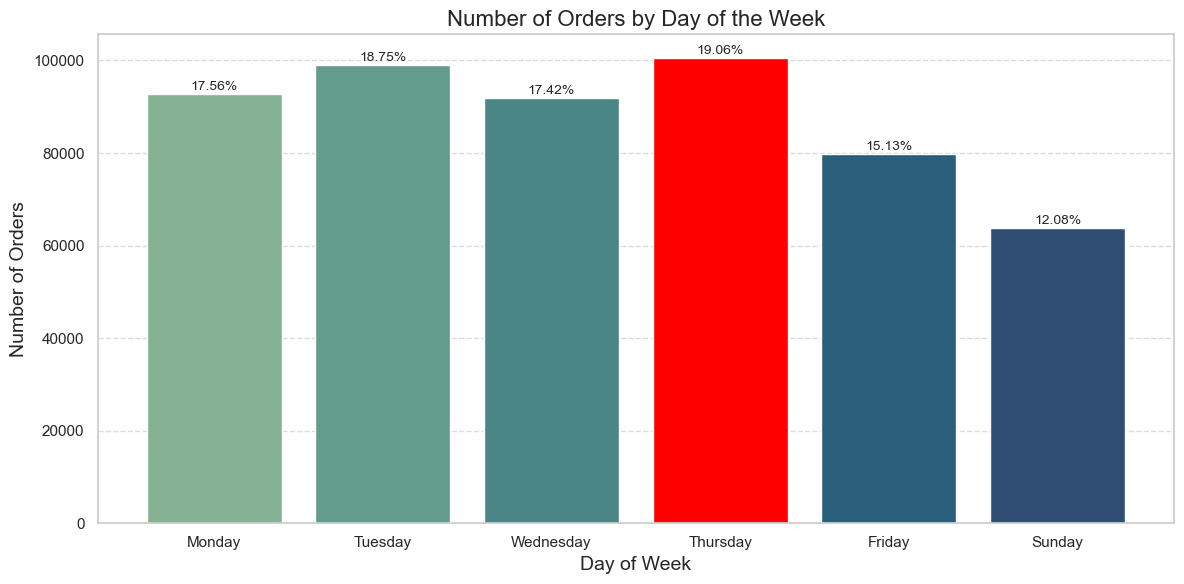

In [ ]:
# Orders per Day of Week
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
orders_by_weekday = df['DayOfWeek'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
).fillna(0)

orders_by_weekday_table = orders_by_weekday.reset_index()
orders_by_weekday_table.columns = ['DayOfWeek', 'Number of Orders']
orders_by_weekday_table['% of Total Orders'] = (orders_by_weekday_table['Number of Orders'] / orders_by_weekday_table['Number of Orders'].sum() * 100).round(2)

# Find Peak Day
peak_idx_day = orders_by_weekday_table['Number of Orders'].idxmax()
peak_day = orders_by_weekday_table.loc[peak_idx_day, 'DayOfWeek']
peak_orders_day = orders_by_weekday_table.loc[peak_idx_day, 'Number of Orders']
peak_percent_day = orders_by_weekday_table.loc[peak_idx_day, '% of Total Orders']

# Plot
plt.figure(figsize=(12,6))

# Palette
colors = sns.color_palette("crest", len(orders_by_weekday_table))

sns.barplot(x='DayOfWeek', y='Number of Orders', data=orders_by_weekday_table, palette=colors)
plt.title('Number of Orders by Day of the Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Annotate % on bars
for index, row in orders_by_weekday_table.iterrows():
    plt.text(index, row['Number of Orders'] + 200, f"{row['% of Total Orders']}%", 
             ha='center', va='bottom', fontsize=10)

# Highlight Peak Day in Red
plt.bar(peak_day, peak_orders_day, color='red')

plt.tight_layout()
plt.show()


Orders are well-distributed across weekdays, peaking on **Thursday** with **19.06%** of all transactions.  
Monday, Tuesday, and Wednesday show similar strong volumes.


### 4.6 Orders by Hour of the Day Analysis

Additionally I explore here the customer shopping behavior by hour.  
Each point is annotated with its percentage share, and the peak ordering hour is highlighted to clearly show the busiest time for orders.



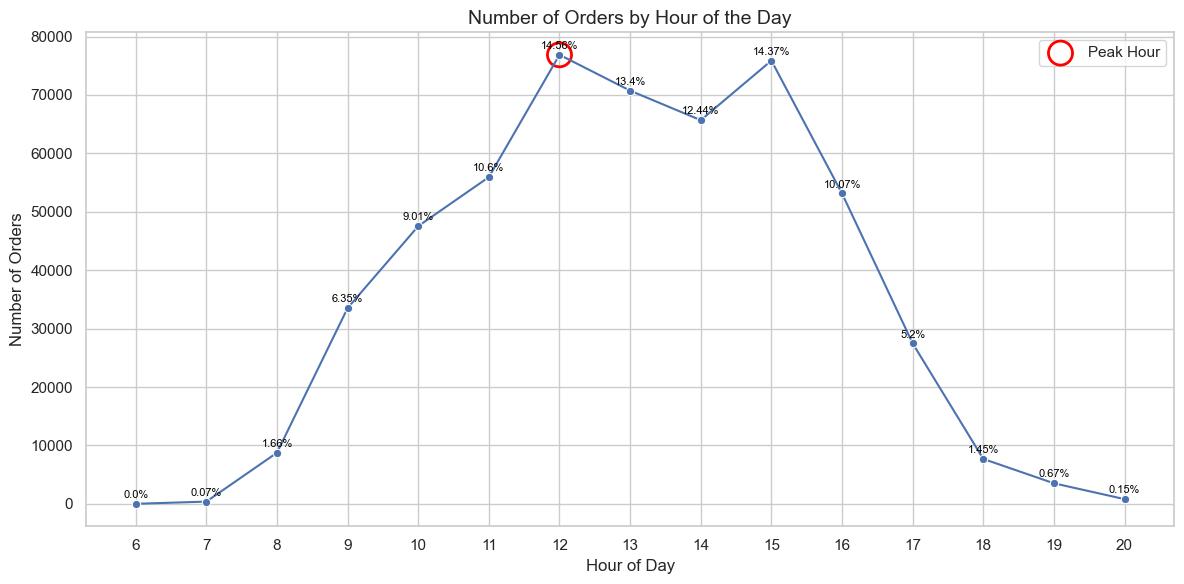

In [ ]:
# Orders per Hour 
df['Hour'] = df['InvoiceDate'].dt.hour
orders_by_hour = df['Hour'].value_counts().sort_index()

orders_by_hour_table = orders_by_hour.reset_index()
orders_by_hour_table.columns = ['Hour', 'Number of Orders']
orders_by_hour_table['% of Total Orders'] = (orders_by_hour_table['Number of Orders'] / orders_by_hour_table['Number of Orders'].sum() * 100).round(2)

# Find Peak Hour
peak_idx_hour = orders_by_hour_table['Number of Orders'].idxmax()
peak_hour = orders_by_hour_table.loc[peak_idx_hour, 'Hour']
peak_orders_hour = orders_by_hour_table.loc[peak_idx_hour, 'Number of Orders']

# Plot
plt.figure(figsize=(12,6))

sns.lineplot(x='Hour', y='Number of Orders', data=orders_by_hour_table, marker='o')
plt.title('Number of Orders by Hour of the Day', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.xticks(range(0,24))

# Annotate % on points (small black text)
for index, row in orders_by_hour_table.iterrows():
    plt.text(row['Hour'], row['Number of Orders'] + 1000, f"{row['% of Total Orders']}%", 
             ha='center', fontsize=8, color='black')

# Highlight Peak Hour 
plt.scatter(peak_hour, peak_orders_hour, edgecolors='red', facecolors='none', s=300, linewidths=2, label='Peak Hour')

plt.legend()
plt.tight_layout()
plt.show()


Order activity steadily increases throughout the morning, peaking at **12 PM** with **14.56%** of all orders.  
After midday, there’s a gradual decline, especially after **4 PM**, reflecting typical business and shopping behavior patterns.


### 4.7 Daily and Monthly Revenue Analysis

Understanding revenue patterns over time helps uncover customer behavior, seasonality, and potential operational issues.  
In this section, I first analyze **daily revenue**, then **monthly revenue**, providing both granular and strategic views of business performance.


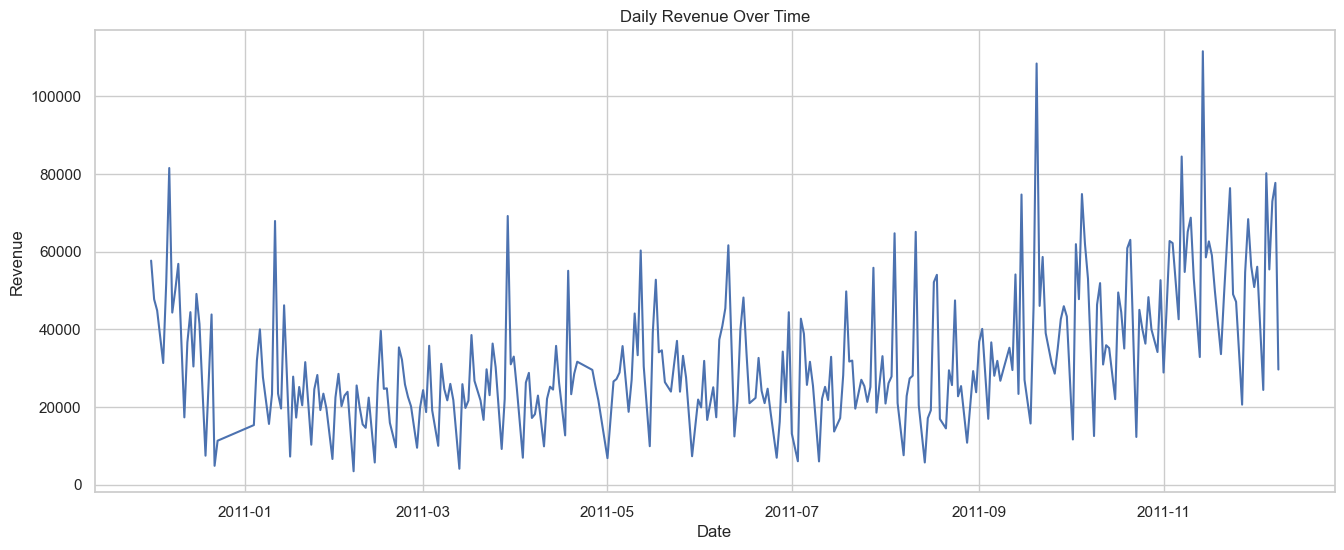

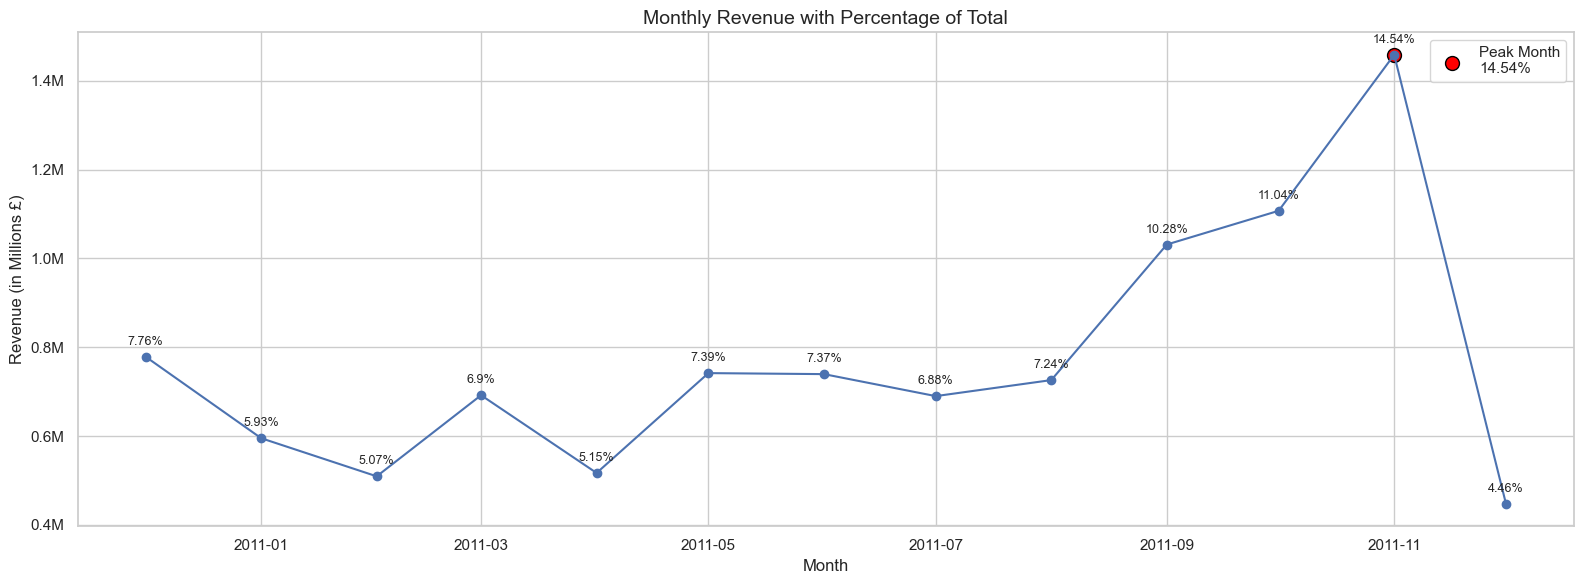

In [ ]:
# Aggregate Revenue by Day
daily_revenue = df.groupby(df['InvoiceDate'].dt.date)['Revenue'].sum()

# Plot Daily Revenue
plt.figure(figsize=(16,6))
plt.plot(daily_revenue.index, daily_revenue.values)
plt.title('Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

# Aggregate Revenue by Month
monthly_revenue = df.groupby(df['InvoiceDate'].dt.to_period('M'))['Revenue'].sum()
monthly_revenue.index = monthly_revenue.index.to_timestamp()

# Calculate % of Total Revenue
monthly_revenue_percent = (monthly_revenue / monthly_revenue.sum() * 100).round(2)

# Identify Peak Month
peak_month_idx = monthly_revenue.idxmax()
peak_month_value = monthly_revenue.loc[peak_month_idx]
peak_month_pct = monthly_revenue_percent.loc[peak_month_idx]

# Plot
plt.figure(figsize=(16,6))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o')

# Annotate percentages
for i in range(len(monthly_revenue)):
    plt.text(monthly_revenue.index[i], monthly_revenue.values[i]+20000, 
             f"{monthly_revenue_percent.iloc[i]}%", 
             ha='center', va='bottom', fontsize=9)

# Highlight Peak Month
plt.scatter(peak_month_idx, peak_month_value, color='red', s=100, edgecolor='black', label=f'Peak Month\n{peak_month_pct}%')

# Titles and Labels
plt.title('Monthly Revenue with Percentage of Total', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Revenue (in Millions £)')

# Format Y-axis to Millions
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))

# Legend and Grid
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



- **Daily Revenue:**  
  Revenue is highly volatile early in the year, with many low-revenue days.  
  From mid-year onwards (June to December), revenue becomes stronger and more consistent, with major peaks around September and November.

- **Monthly Revenue:**  
  Monthly trends show steady growth across the year, with a sharp surge in November **14.54%** (likely holiday season).  
  December shows a dip due to incomplete data capture, not an actual decline.

Overall, the business gained momentum in the second half of the year, supported by seasonal effects and increased customer activity.


### 4.8 Correlation Heatmap

Here i have Examined the relationships between numeric variables to uncover dependencies (e.g., Quantity vs. Revenue).

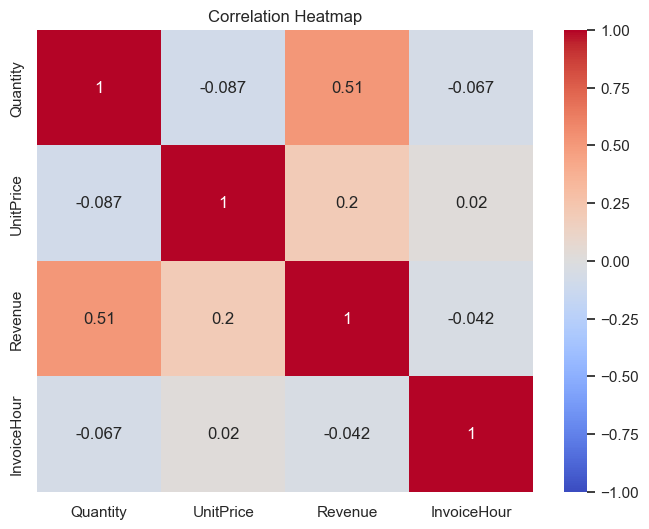

In [240]:
numeric_cols = ['Quantity', 'UnitPrice', 'Revenue', 'InvoiceHour']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

Revenue strongly correlates with Quantity (0.51) but weakly with UnitPrice (0.2), indicating quantity drives revenue more than price and also InvoiceHour shows minimal correlation with others.

### 4.9 Top Products by Quantity and Revenue

Now i would like to compare top products by volume and value to identify high-demand vs. high-profit items.

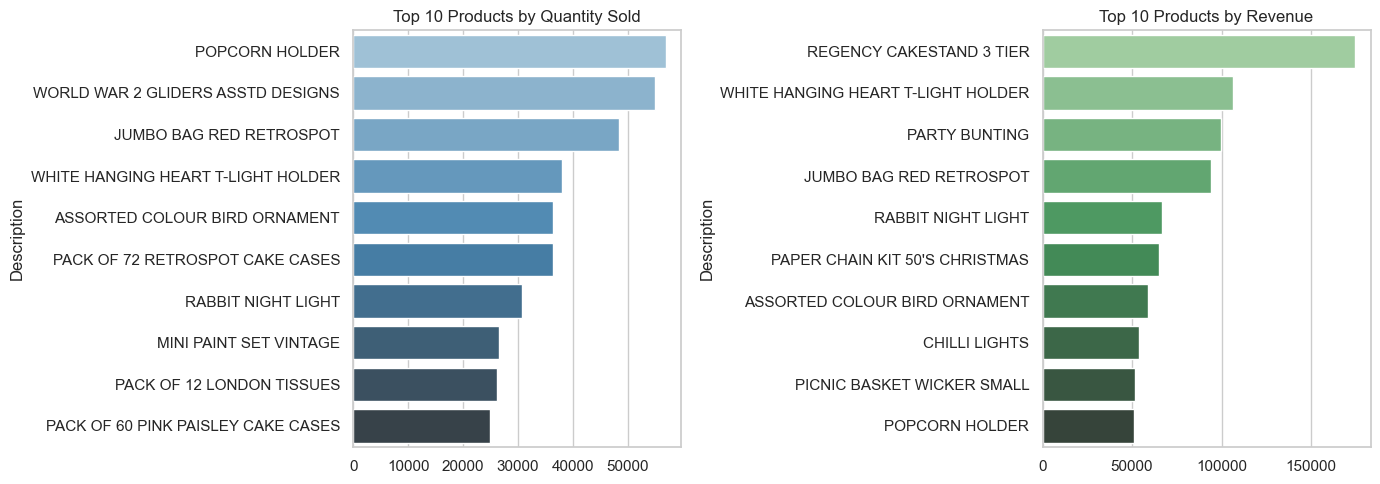

In [241]:
top_products_qty = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products_rev = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=top_products_qty.values, y=top_products_qty.index, palette='Blues_d')
plt.title("Top 10 Products by Quantity Sold")
plt.subplot(1, 2, 2)
sns.barplot(x=top_products_rev.values, y=top_products_rev.index, palette='Greens_d')
plt.title("Top 10 Products by Revenue")
plt.tight_layout()
plt.show()

- **Popcorn Holder** leads in terms of quantity sold, indicating a very high customer demand.
- **Regency Cakestand 3 Tier** generates the highest revenue, suggesting it is a premium-priced item with strong profitability.

Understanding the difference between high-volume and high-revenue products can guide inventory management and marketing focus.

### 4.10 Top Customers by Revenue

Now I want to Analyze the customer revenue highlights the most valuable clients.  
Focusing on top spenders can guide loyalty programs and personalized marketing efforts.


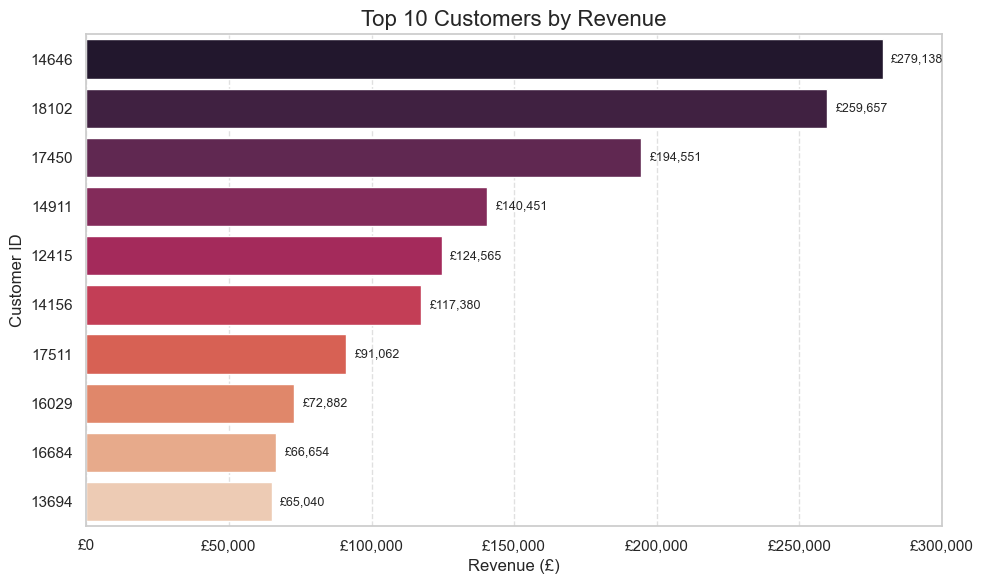

In [251]:
# Group Revenue by Customer (excluding guest -1)
top_customers = df[df['CustomerID'] != -1].groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False).head(10)

# Reset index and clean CustomerID
top_customers = top_customers.reset_index()
top_customers['CustomerID'] = top_customers['CustomerID'].astype(int).astype(str)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Revenue', y='CustomerID', data=top_customers, palette='rocket')

# Titles and labels
plt.title('Top 10 Customers by Revenue', fontsize=16)
plt.xlabel('Revenue (£)', fontsize=12)
plt.ylabel('Customer ID', fontsize=12)

# Annotate Revenue on Bars
for index, row in top_customers.iterrows():
    plt.text(row['Revenue'] + 3000, index, f"£{row['Revenue']:,.0f}", va='center', fontsize=9)

# Professional Axis Formatting
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}'))
plt.xlim(0, 300000)  # <-- Extend axis to 300,000

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 4.11 Product Co-occurrence

Identifying frequently purchased product pairs, providing insights into customer behavior and potential bundling opportunities.

In [242]:
# Create StockCode-to-Description mapping
stockcode_desc = df[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description']

# Calculate co-occurrences
invoice_products = df.groupby('InvoiceNo')['StockCode'].apply(
    lambda x: [code for code in x if pd.notna(code)]
)
co_occurrences = Counter()
for products in invoice_products:
    if len(products) > 1:
        co_occurrences.update(combinations(products, 2))

# Get top 10 with descriptions
top_co_occurrences = pd.DataFrame(co_occurrences.most_common(10), columns=['ProductPair', 'Count'])
top_co_occurrences['Product1'] = top_co_occurrences['ProductPair'].apply(lambda x: stockcode_desc.get(x[0], x[0]))
top_co_occurrences['Product2'] = top_co_occurrences['ProductPair'].apply(lambda x: stockcode_desc.get(x[1], x[1]))
print("Top 10 Product Co-occurrences:")
print(top_co_occurrences[['Product1', 'Product2', 'Count']])
print(f"Total unique invoices processed: {len(invoice_products)}")



Top 10 Product Co-occurrences:
                            Product1                         Product2  Count
0    GREEN REGENCY TEACUP AND SAUCER   PINK REGENCY TEACUP AND SAUCER    612
1            JUMBO BAG PINK POLKADOT          JUMBO BAG RED RETROSPOT    542
2    GREEN REGENCY TEACUP AND SAUCER  ROSES REGENCY TEACUP AND SAUCER    526
3  JUMBO SHOPPER VINTAGE RED PAISLEY          JUMBO BAG RED RETROSPOT    466
4             JUMBO STORAGE BAG SUKI          JUMBO BAG RED RETROSPOT    455
5            LUNCH BAG RED RETROSPOT           LUNCH BAG BLACK SKULL.    440
6     PINK REGENCY TEACUP AND SAUCER  ROSES REGENCY TEACUP AND SAUCER    414
7            JUMBO BAG RED RETROSPOT    JUMBO BAG BAROQUE BLACK WHITE    394
8         ALARM CLOCK BAKELIKE GREEN         ALARM CLOCK BAKELIKE RED    393
9                   JUMBO BAG APPLES          JUMBO BAG RED RETROSPOT    391
Total unique invoices processed: 19785


## 5 Advance Analytics

### 5.1 Customer Segmentation: RFM (Recency, Frequency, Monetary) Analysis

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries.

*RFM stands for the three dimensions:*

**Recency** – How recently did the customer purchase?   
**Frequency** – How often do they purchase?     
**Monetary** – How much do they spend?  

*Recency - In order to find the recency value of each customer, we need to determine the last invoice date as the current date and subtract the last purchasing date of each customer from this date.*

*Frequency - In order to find the frequency value of each customer, we need to determine how many times the customers make purchases.*

*Monetary - In order to find the monetary value of each customer, we need to determine how much do the customers spend on purchases.*


In [268]:
# Set the 'today' date (maximum date in dataset + 1 day)
today_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID and calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                # Frequency
    'Revenue': 'sum'                                       # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Drop Guest Customer (CustomerID = -1 if still exists)
rfm = rfm[rfm['CustomerID'] != -1]

# Convert CustomerID to integer (professional format)
rfm['CustomerID'] = rfm['CustomerID'].astype(int)

# Quick View
rfm.head(10)


,CustomerID,Recency,Frequency,Monetary
1,12347,2,7,4310.00
2,12348,75,4,1437.24
3,12349,19,1,1457.55
4,12350,310,1,294.40
5,12352,36,7,1385.74
6,12353,204,1,89.00
7,12354,232,1,1079.40
8,12355,214,1,459.40
9,12356,23,3,2487.43
10,12357,33,1,6207.67


From the sample RFM table:

- Customer **12347** is highly active, purchasing recently (Recency = 2 days) with high Frequency (7 purchases) and strong Monetary value (£4,310).
- Customer **12348** is moderately active but with slightly older Recency (75 days) and moderate spending.
- Customer **12349**, **12350**, and others have much lower Frequency (only 1 order), indicating occasional buyers.
- Customer **12357** stands out with exceptionally high Monetary value (£6,207) despite only one purchase, suggesting a large one-time transaction.
- Overall, recency and frequency vary significantly among customers, highlighting different engagement and value levels.



### 5.2 RFM Scoring Code

To standardize customer behavior into actionable insights, I assign scores from 1 to 5 for each RFM component:

- **Recency (R_Score)**: Customers are divided into 5 groups based on how recently they purchased.  
  - Customers who purchased most recently receive a score of 5 (best), while oldest purchasers receive 1 (lowest).

- **Frequency (F_Score)**: Customers are ranked based on how often they purchased.  
  - Customers with the highest number of purchases receive a score of 5, and infrequent buyers receive lower scores.

- **Monetary (M_Score)**: Customers are grouped based on their total spend.  
  - Higher spending customers receive a score of 5, lower spending customers receive lower scores.

- **RFM_Score**: Finally, the individual scores are concatenated into a 3-digit code to fully capture each customer's behavior profile.


In [271]:
# Recency: Lower is better (more recent)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Frequency: Higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Monetary: Higher is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Create RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# View
rfm.head(10)



,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
1,12347,2,7,4310.00,5,5,5,555
2,12348,75,4,1437.24,2,4,4,244
3,12349,19,1,1457.55,4,1,4,414
4,12350,310,1,294.40,1,1,2,112
5,12352,36,7,1385.74,3,5,4,354
6,12353,204,1,89.00,1,1,1,111
7,12354,232,1,1079.40,1,1,4,114
8,12355,214,1,459.40,1,1,2,112
9,12356,23,3,2487.43,4,3,5,435
10,12357,33,1,6207.67,4,1,5,415


From the RFM table:

- **Customer 12347** is a perfect "Champion" with top scores across Recency, Frequency, and Monetary (RFM = 555).
- **Customer 12352** also shows strong Frequency (7 purchases) but slightly older Recency, classified as a potential Loyal Customer (RFM = 354).
- **Customer 12357** spent a very high amount (£6,207) despite low Frequency, indicating a "Big Spender" profile (RFM = 415).
- Customers like **12350**, **12353**, and **12355** have low Recency, Frequency, and Monetary scores (e.g., 112, 111), signaling they are "At Risk" of churn.
- Overall, RFM scores reveal diverse customer behaviors, highlighting opportunities for targeted engagement.


### 5.3 Visualization of RFM Distributions

To better understand the spread and behavior of customer metrics, I would like to visualize the distribution of Recency, Frequency, and Monetary scores. These plots help reveal customer purchasing patterns, data skewness, and potential segmentation opportunities.


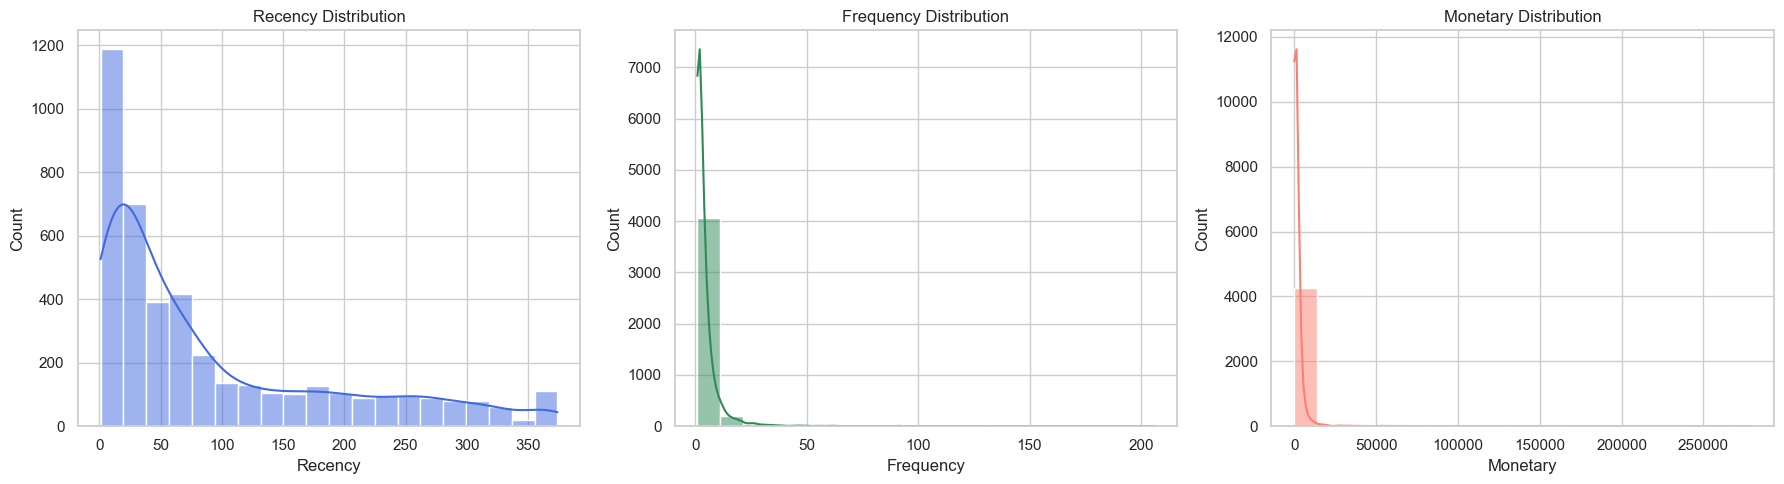

In [272]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=20, kde=True, ax=axes[0], color='royalblue')
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=20, kde=True, ax=axes[1], color='seagreen')
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=20, kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()


- **Recency** is heavily right-skewed, meaning most customers purchased recently, but a few have not interacted for a long time.
- **Frequency** shows that the majority of customers have very few purchases, while a small group of highly loyal customers exists.
- **Monetary** is extremely skewed, with most customers generating low revenue, and a few contributing significantly higher amounts.

These patterns highlight that customer behavior is not evenly distributed, which justifies segmenting them into meaningful groups for targeted strategies.


### 5.4 Customer Segmentation Based on RFM Scores

Using the RFM scoring system, I segment customers into meaningful groups such as **Champions**, **Loyal Customers**, **At Risk**, and others.  
Each group reflects distinct customer behaviors regarding purchase frequency, recent engagement, and monetary value.  
This segmentation allows businesses to apply tailored marketing strategies — boosting retention, encouraging high-value customers, and reactivating dormant ones.



In [276]:

def segment_customer(rfm):
    if rfm['R_Score'] >= 4 and rfm['F_Score'] >= 4 and rfm['M_Score'] >= 4:
        return 'Champion'
    elif rfm['R_Score'] >= 3 and rfm['F_Score'] >= 3:
        return 'Loyal Customer'
    elif rfm['R_Score'] >= 4:
        return 'Recent Customer'
    elif rfm['F_Score'] >= 4:
        return 'Frequent Buyer'
    elif rfm['M_Score'] >= 4:
        return 'Big Spender'
    elif rfm['R_Score'] <= 2 and rfm['F_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Others'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# View
rfm[['CustomerID', 'RFM_Score', 'Segment']].head(10)


,CustomerID,RFM_Score,Segment
1,12347,555,Champion
2,12348,244,Frequent Buyer
3,12349,414,Recent Customer
4,12350,112,At Risk
5,12352,354,Loyal Customer
6,12353,111,At Risk
7,12354,114,Big Spender
8,12355,112,At Risk
9,12356,435,Loyal Customer
10,12357,415,Recent Customer


- **Champions** like Customer 12347 (RFM 555) are highly engaged, frequent, and valuable buyers — top priority for retention.
- **Loyal Customers** such as 12352 and 12356 consistently buy and remain active but could be motivated for higher spend.
- **Recent Customers** like 12349 and 12357 are new buyers showing promising engagement.
- **Frequent Buyers** (e.g., 12348) purchase often but may not spend heavily.
- **Big Spenders** like 12354 generate high revenue but purchase less frequently.
- **At Risk** customers such as 12350, 12353, and 12355 have low engagement and may churn without intervention.

These insights enable precise, segment-specific strategies to maximize lifetime value across different customer groups.


### 5.5 Visualizing Customer Segment

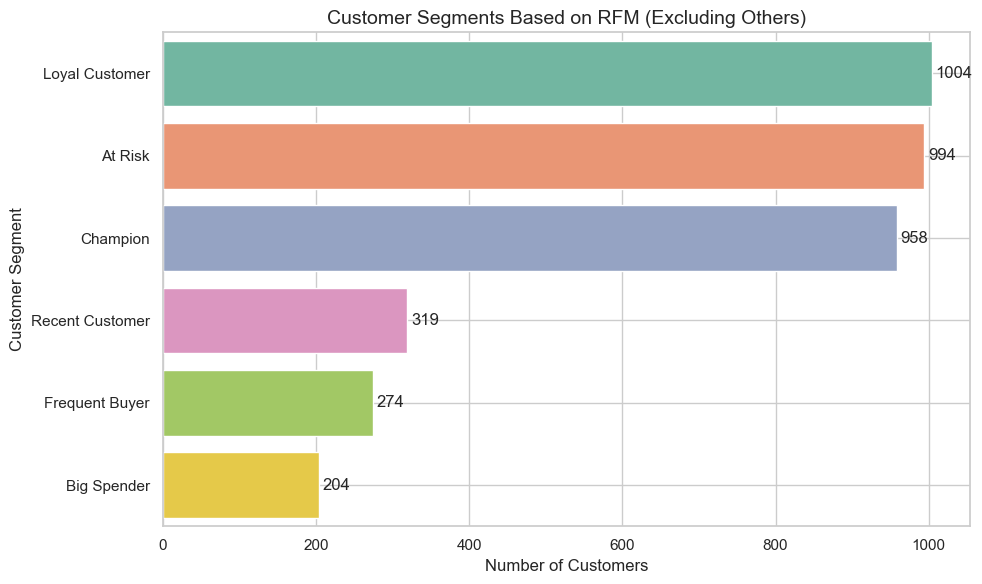

In [278]:
# Calculate segment counts excluding 'Others'
segment_counts = rfm['Segment'].value_counts()
segment_counts = segment_counts[segment_counts.index != 'Others']  # Exclude 'Others'

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=segment_counts.values, y=segment_counts.index, palette='Set2')
plt.title('Customer Segments Based on RFM (Excluding Others)', fontsize=14)
plt.xlabel('Number of Customers')
plt.ylabel('Customer Segment')

# Annotate the bars
for index, value in enumerate(segment_counts.values):
    plt.text(value + 5, index, f"{value}", va='center')  # small shift to avoid overlapping

plt.grid(True)
plt.tight_layout()
plt.show()


- **Loyal Customers** represent the largest group (~1004 customers), highlighting a strong base of repeat buyers who can be further nurtured with loyalty programs and upselling opportunities.
- **At Risk** customers (~994) form a significant portion, signaling the need for reactivation campaigns to prevent churn.
- **Champions** (~958 customers) are highly valuable — they buy often, recently, and spend more. These customers should receive exclusive offers to maintain engagement.
- **Recent Customers** (~319) show promise for future growth if nurtured early.
- **Frequent Buyers** (~274) buy often but might not spend heavily; they can be targeted for premium upselling.
- **Big Spenders** (~204) are fewer but contribute significantly to revenue — personalized experiences can boost their loyalty.


### 5.6 Customer Segment Summary Dashboard

To finalize the customer analysis, I create a compact dashboard summarizing key metrics, including:
- Total customers
- Total revenue
- Average revenue per customer
- Customer segmentation breakdown


Total Customers: 4,334
Total Revenue: £10,033,386.69
Average Revenue per Customer: £2,315.04

Customer Segments:
Segment
Loyal Customer     1004
At Risk             994
Champion            958
Others              581
Recent Customer     319
Frequent Buyer      274
Big Spender         204
Name: count, dtype: int64


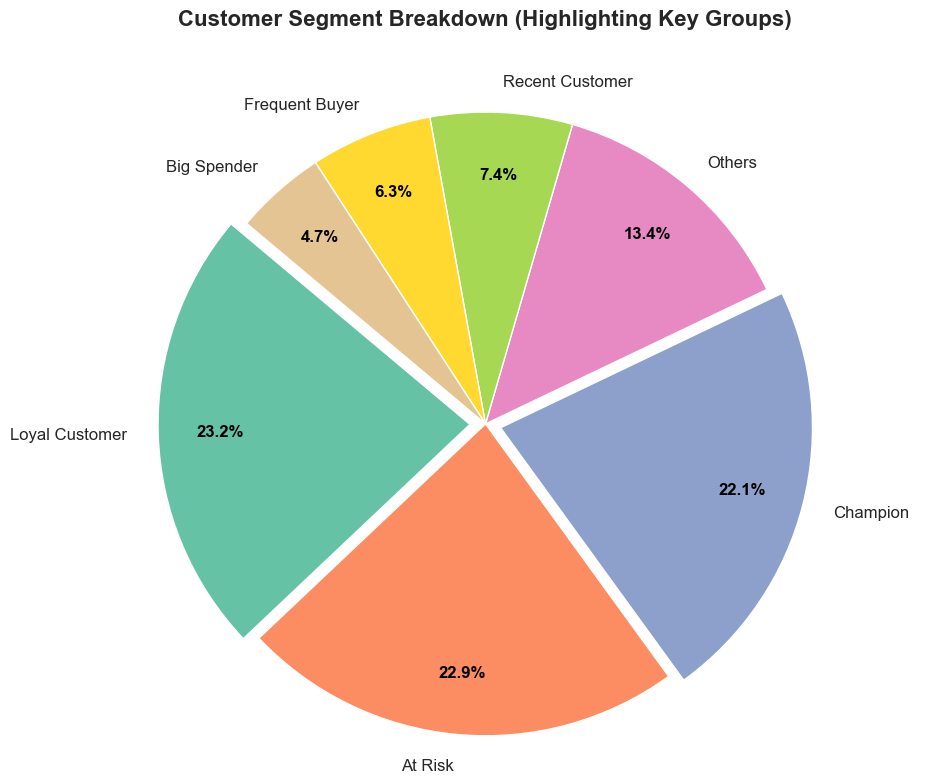

In [285]:
# total customer
total_customers = rfm['CustomerID'].nunique()
total_revenue = df['Revenue'].sum()
avg_revenue_per_customer = total_revenue / total_customers

segment_counts = rfm['Segment'].value_counts()

# Print Summary
print(f"Total Customers: {total_customers:,}")
print(f"Total Revenue: £{total_revenue:,.2f}")
print(f"Average Revenue per Customer: £{avg_revenue_per_customer:,.2f}")
print("\nCustomer Segments:")
print(segment_counts)

# Pie chart visualization
explode = [0.05 if seg in ['Champion', 'Loyal Customer'] else 0 for seg in segment_counts.index]

fig, ax = plt.subplots(figsize=(10,8))
wedges, texts, autotexts = ax.pie(
    segment_counts.values, 
    labels=segment_counts.index, 
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    colors=sns.color_palette('Set2'),
    pctdistance=0.8,
    textprops={'fontsize': 12}
)

# Format text inside
plt.setp(autotexts, size=12, weight="bold", color="black")

# Move Title slightly upwards
plt.title('Customer Segment Breakdown (Highlighting Key Groups)', fontsize=16, weight='bold', pad=40)

ax.axis('equal')  
plt.tight_layout()
plt.show()


The customer segmentation pie chart reveals that **Loyal Customers** (23.2%) and **Champions** (22.1%) together make up nearly half of the customer base, highlighting a strong foundation of engaged and valuable customers.

However, a significant portion (22.9%) falls into the **At Risk** segment, signaling the need for re-engagement strategies.

Smaller but important groups such as **Frequent Buyers** (6.3%), **Recent Customers** (7.4%), and **Big Spenders** (4.7%) present targeted opportunities for growth and personalized marketing campaigns.


### 5.7 Revenue Contribution by Customer Segment
In this section, I assess the business value of each RFM-based customer segment.                
By calculating the **total** and **average** revenue contribution per segment, I can identify which groups drive the business financially.
This helps prioritize marketing efforts towards the most valuable segments.


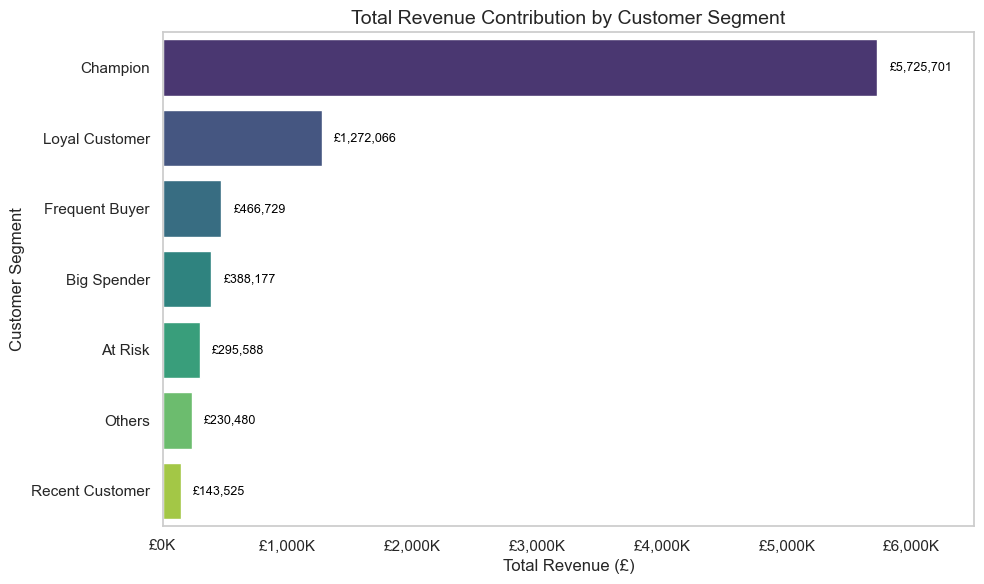

,sum,count
Segment,,
Champion,5725700.970,234945
Loyal Customer,1272065.700,79805
Frequent Buyer,466729.080,22120
Big Spender,388176.770,12675
At Risk,295587.510,19423
Others,230479.641,17243
Recent Customer,143524.780,10269


In [292]:
import matplotlib.ticker as mticker

# Aggregate Revenue per Segment
segment_revenue = df.merge(rfm[['CustomerID', 'Segment']], on='CustomerID')
revenue_per_segment = segment_revenue.groupby('Segment')['Revenue'].agg(['sum', 'mean', 'count']).sort_values(by='sum', ascending=False)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x=revenue_per_segment['sum'], y=revenue_per_segment.index, palette="viridis")
plt.title('Total Revenue Contribution by Customer Segment', fontsize=14)
plt.xlabel('Total Revenue (£)', fontsize=12)
plt.ylabel('Customer Segment', fontsize=12)

# Format x-axis nicely
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'£{int(x/1000):,}K'))

# Extend x-axis to allow text outside the bar
plt.xlim(0, 6500000)  # → a little beyond 6M so that Champion fits comfortably

# Annotate outside the bars
for index, value in enumerate(revenue_per_segment['sum']):
    plt.text(value + 100000, index, f'£{value:,.0f}', va='center', ha='left', fontsize=9, color='black')

plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Quick View
revenue_per_segment[['sum', 'count']]


The bar plot reveals that **Champion** customers overwhelmingly dominate revenue generation, contributing over £5.7 million.
**Loyal Customers** follow with a significant gap, around £1.27 million.
Other segments like **Frequent Buyers** and **Big Spenders** contribute moderately, while **At Risk** and **Recent Customers** generate lower revenues.
This indicates that **retaining Champions and Loyal Customers** should be a top strategic priority for maximizing future business growth.


### 5.8 RFM Heatmap Profiling
To better understand the behavior of each customer segment, I calculate and visualize the average Recency, Frequency, and Monetary scores.
This heatmap provides an intuitive customer profile for strategic decision-making.


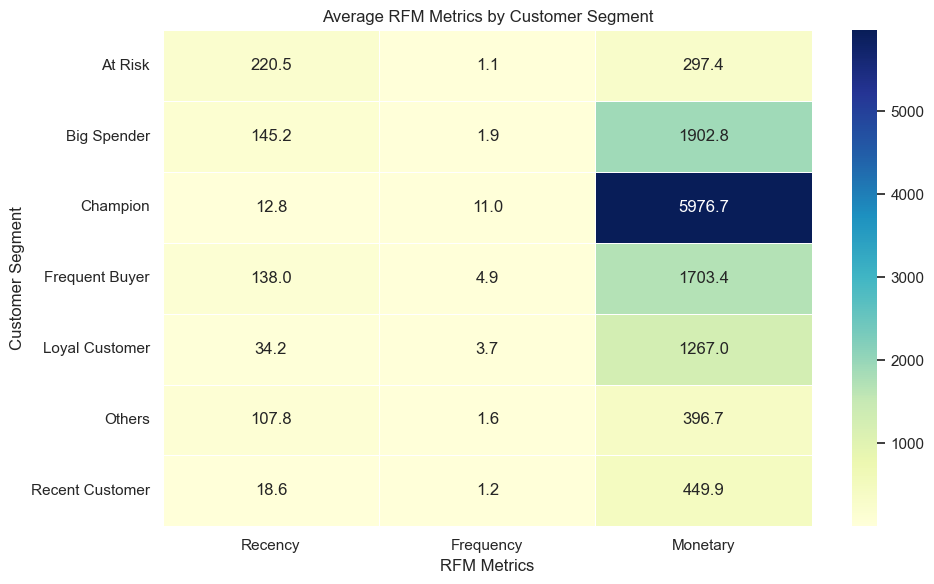

In [288]:
# Average RFM Scores per Segment
rfm_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(rfm_summary, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5)
plt.title('Average RFM Metrics by Customer Segment')
plt.ylabel('Customer Segment')
plt.xlabel('RFM Metrics')
plt.tight_layout()
plt.show()


- **Champions** have the **lowest Recency** (12.8 days), **highest Frequency** (11 orders), and **highest Monetary value** (£5,976.7), confirming their status as top, loyal, and profitable customers.
- **Loyal Customers** show relatively **low Recency** (34.2) and moderate Frequency (3.7), making them valuable but with lower spending per customer than Champions.
- **Frequent Buyers** make purchases often (4.9 orders) but contribute lower revenue (£1,703.4) compared to Champions.
- **Big Spenders** have high Monetary value (£1,902.8) despite lower Frequency (1.9), meaning fewer but high-value purchases.
- **At Risk** customers show **very high Recency** (220.5 days) and **low Frequency** (1.1), indicating long inactivity and very low contribution.
- **Recent Customers** have low Recency (18.6) but low Frequency and Monetary values, suggesting they are new but not yet loyal.
- **Others** show weak performance across all dimensions, confirming they are not strong targets for immediate marketing focus.

This matrix confirms that strategic marketing should focus primarily on retaining **Champions** and **Loyal Customers**, while reactivating **At Risk** customers could also unlock hidden revenue.



### Predictive Modeling (Forecasting Future Purchases)

## Insights and Business Impact

## Conclusion

## References